## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II
# Micro-Proyecto 1

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

### Integrantes
* Camilo Andres Suarez Trillos | 200321493 
* Carlos Francisco Silva Ortiz | 201920463
* Juan Camilo Florez Caro | 201620135 


### Introducción
Una *start-up* agrícola quiere construir una aplicación online que conecte el campo
con la ciudad de manera directa y sin intermediarios. De esta manera, los agricultores ponen a la disposición de la empresa sus distintos productos, y la start-up se encarga de atender las necesidades de demanda distribuyendo los productos hasta los clientes finales en la ciudad.

Para optimizar la gestión logística y desarrollar esta labor de manera eficiente, los dueños de la *start-up* han visto la necesidad de diseñar e implementar un sistema de gestión y predicción que les permita planear con la debida anticipación la demanda esperada. Así podrán coordinar las actividades de producción, junto con los agricultores, y atender la demanda mientras se minimizan las pérdidas por unidades de producto no vendido o estropeado. 

Este es un reto altamente relevante para la sostenibilidad de la industria alimentaria, donde gran cantidad de las pérdidas se refieren a grupos alimenticios donde la frescura del producto es un importante criterio para el consumo. El desperdicio de los alimentos se relaciona con el sobre-pedido o el sobre-almacenamiento, lo cual puede a su vez ser consecuencia de dificultades en el pronóstico de la demanda. Este problema es aun más marcado a medida que uno sube en la cadena de producción y se aleja de los patrones de comportamiento del consumidor final. 

Por lo tanto, la start-up agrícola debe gestionar los inventarios de manera inteligente, disminuyendo la ventana de tiempo entre cosecha y consumo. Para ello, necesita desarrollar modelos de predicción de demanda que apoyen su operación, logrando la disponibilidad de los productos para atender a los clientes del día siguiente, minimizando los desperdicios de alimentos e identificando hábitos de consumo que le permita optimizar sus operaciones logísticas y de negocio.

### Enunciado
Por ello se le pide a usted, en calidad de consultor externo, desarrollar un modelo predictivo de demanda para los productos más relevantes con los que trabaja la start-up agrícola, obteniendo una predicción a nivel semanal (una semana adelante). Los datos los encuentra en el archivo DatosAgro.txt, donde se tiene la identificación del cliente, la fecha en que realizó el pedido, la magnitud del pedido (en unidades según lo especificado en el nombre del producto), su precio, y el código del producto agrícola que consta en el pedido.

## 1. Visualicemos los datos

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from datetime import datetime
from fbprophet import Prophet

In [3]:
# Importemos los datos y visualizemos la serie de tiempo
data = pd.read_csv("DatosAgro.txt", delimiter='\t', encoding="utf8")
data = data.drop('Unnamed: 6', 1)
data['Fecha'] = pd.to_datetime(data['Fecha'])
data.head()

,Cliente,Fecha,Pedido,Precio,Producto,Nombre_producto
0,Cliente26,2017-09-18,20,700,VER0049,Yerbabuena / 100 gramos
1,Cliente26,2017-09-18,10,1200,FRU0024,Limón Tahití / Libra
2,Cliente26,2017-09-18,4,1600,VER0041,Puerro / Libra
3,Cliente26,2017-09-18,10,1500,VER0038,Pimentón Rojo / Libra
4,Cliente26,2017-09-18,8,1100,VER0010,Zucchini Verde / Libra


Veamos los clientes con mayor participación en la demanda:

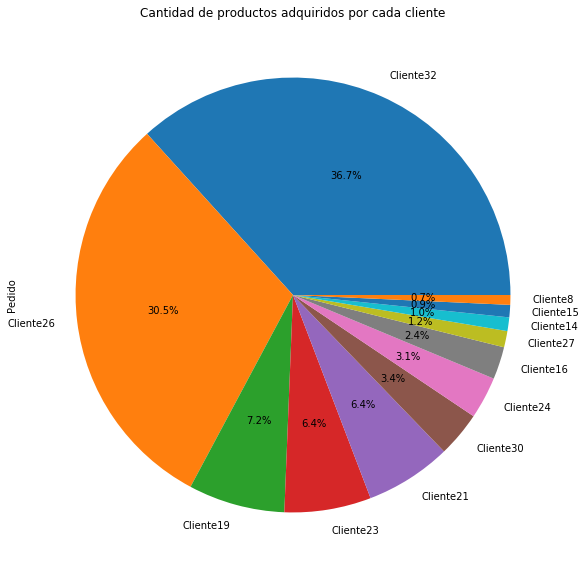

In [4]:
cliente = pd.DataFrame(data[data['Pedido'] > 10].groupby(data["Cliente"]).sum())
cliente2 = cliente[cliente['Pedido']>50]
cliente3 = cliente2.sort_values("Pedido", ascending= False)
cliente3.plot.pie(y='Pedido', figsize=(10, 10), legend=False, autopct='%1.1f%%')
plt.title("Cantidad de productos adquiridos por cada cliente")
plt.show()


Vemaos los productos con más volumen de pedido:

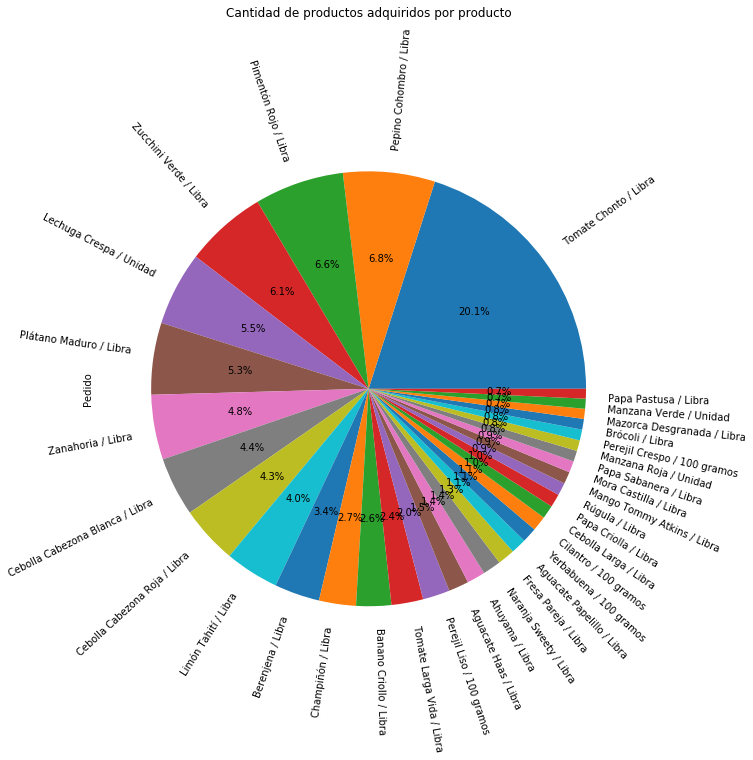

In [5]:
productos = pd.DataFrame(data["Pedido"].groupby(data["Nombre_producto"]).sum())
productos2 = productos[productos['Pedido']>140]
productos3 = productos2.sort_values("Pedido", ascending= False)
productos3.plot.pie(y='Pedido', figsize=(10, 10), legend=False, autopct='%1.1f%%', rotatelabels=True)
plt.title("Cantidad de productos adquiridos por producto", pad=100)
plt.show()

### Validamos cantidad de clientes y productos

In [6]:
#Revisamos cantidad de clientes y pedidos por clientes
cantclientes = pd.DataFrame(data["Pedido"].groupby(data["Cliente"]).count()).sort_values(by="Pedido", ascending=False)
print("Hay un total de", np.int(cantclientes.count()), "clientes")
print("La cantidad de pedidos por cliente va desde", np.int(cantclientes.min()), "hasta", np.int(cantclientes.max()))

Hay un total de 33 clientes
La cantidad de pedidos por cliente va desde 4 hasta 932


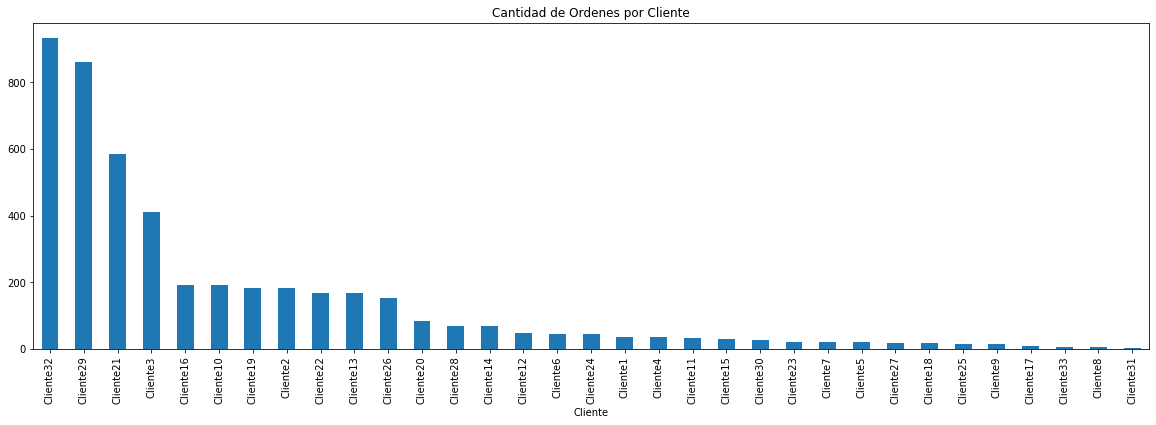

In [7]:
cantclientes.plot.bar(figsize=(20,6), legend=False)
plt.title('Cantidad de Ordenes por Cliente')
plt.show()

In [9]:
#Cantidad de unidades pedidas
cantidades = pd.DataFrame(data["Pedido"].groupby(data["Producto"]).sum()).sort_values(by="Pedido", ascending=False)
#Filtramos los productos relevantes, es decir, aquellos que tengan una participación mínima del 0.5% del total de los pedidos de la muestra observada
prod = cantidades[cantidades['Pedido']>=np.int(np.sum(cantidades)*0.005)]
prod = prod.index
dataprod = data[data["Producto"].isin(prod)]
demanda = pd.DataFrame(dataprod["Pedido"].groupby(dataprod["Nombre_producto"]).sum()).sort_values(by="Pedido", ascending=False)
print("Hay un total de", np.int(demanda.count()), "productos diferentes")
print("La cantidad unidades pedidas por producto va desde", np.int(demanda.min()), "hasta", np.int(demanda.max()))

Hay un total de 38 productos diferentes
La cantidad unidades pedidas por producto va desde 116 hasta 4000


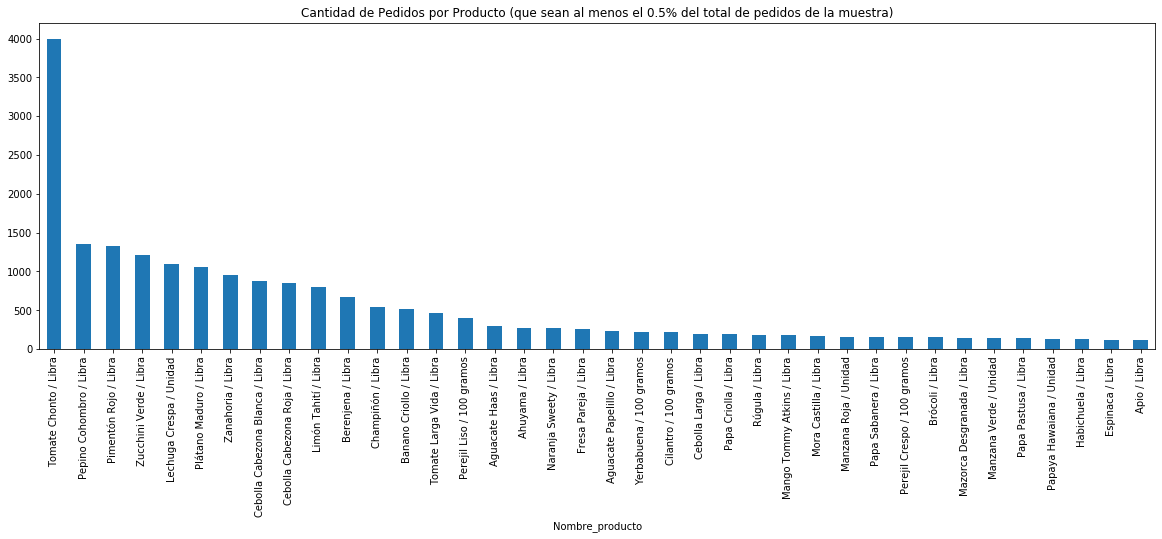

In [10]:
demanda.plot.bar(figsize=(20,6), legend=False)
plt.title('Cantidad de Pedidos por Producto (que sean al menos el 0.5% del total de pedidos de la muestra)')
plt.show()

In [12]:
#Fechas
fechas = pd.DataFrame(data["Pedido"].groupby(data["Fecha"]).count()).sort_values(by="Fecha", ascending=False)
print("Hay un total de", np.int(fechas.count()), "Fechas")
print("La cantidad de pedidos por fecha va desde", np.int(fechas.min()), "hasta", np.int(fechas.max()))

Hay un total de 242 Fechas
La cantidad de pedidos por fecha va desde 2 hasta 97


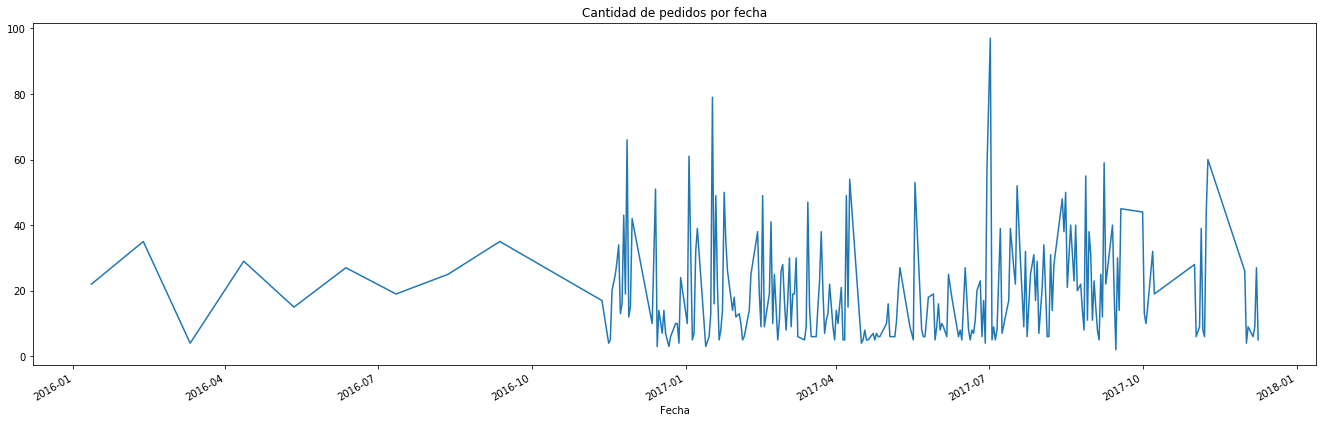

In [13]:
fechas.plot(figsize=(23,7), legend=False)
plt.title("Cantidad de pedidos por fecha")
plt.show();

In [15]:
#Ajustamos el dataframe original a frecuencia semanal, esto lo hacemos primero restando 7 días, ya que lo que queremos es agrupar la demanda al fin de esa semana, no a la semana anterior
data2 = data.groupby(['Producto','Nombre_producto', pd.Grouper(key='Fecha', freq='W')])['Pedido'].sum().reset_index().sort_values('Fecha',ascending=False)

In [16]:
pedidos_sem = pd.DataFrame(data2["Pedido"].groupby(data2["Fecha"]).count()).sort_values(by="Fecha", ascending=True)
print("Hay un total de", np.int(pedidos_sem.count('index')), "Semanas")
print("La cantidad de pedidos por semana va desde", np.int(pedidos_sem.min()), "hasta", np.int(pedidos_sem.max()))

Hay un total de 60 Semanas
La cantidad de pedidos por semana va desde 4 hasta 88


In [19]:
data3 = data2[data2['Producto'].isin(prod)]
pvt = data3.pivot(index='Fecha', columns='Producto', values ='Pedido').reset_index()
primer_sem = np.min(pd.DataFrame(data3["Pedido"].groupby(data3["Fecha"]).sum()).index)
semanas = primer_sem + pd.to_timedelta(np.arange(100), 'W')
semanas = pd.DataFrame(semanas, columns=["Fecha"])
df = pd.merge(semanas, pvt, how='left').sort_index().fillna(0)
df

,Fecha,FRU0002,FRU0003,FRU0008,FRU0016,FRU0024,FRU0028,FRU0029,FRU0030,FRU0033,...,VER0020,VER0024,VER0028,VER0035,VER0037,VER0038,VER0049,VER0050,VER0051,VER0052
0,2016-01-17,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-02-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-02-14,0.0,5.0,8.0,2.0,6.0,0.0,0.0,5.0,1.0,...,2.0,0.0,2.0,9.0,1.0,9.0,1.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2017-11-12,14.0,5.0,16.0,16.0,19.0,9.0,0.0,0.0,7.0,...,4.0,0.0,18.0,4.0,3.0,30.0,0.0,11.0,0.0,47.0
96,2017-11-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,2017-11-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,2017-12-03,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,2.0,...,0.0,0.0,8.0,18.0,7.0,34.0,3.0,0.0,2.0,0.0


In [62]:
mdl = list()
for i in range(1,df.shape[1]):
    df1 = df.iloc[:,[0,i]].copy()
    colname = df.columns[i]
    df1 = df1.rename(columns={"Fecha":"ds",colname:"y"})
    m = Prophet(yearly_seasonality=True, changepoint_prior_scale=10, changepoints=['2016-11-13'], weekly_seasonality=False, daily_seasonality=False)
    m.fit(df1)
    future = m.make_future_dataframe(periods=1, freq='w')
    fcst = m.predict(future)
    mdl.append(fcst)
    forecast=fcst[['ds', 'yhat']]
    if i == 1:
        forecast_comp = forecast.rename(columns={"yhat" : colname})
    if i > 1:
        forecast_comp = forecast_comp.join(forecast.set_index('ds'), on='ds')
        forecast_comp = forecast_comp.rename(columns={"yhat" : colname})

In [30]:
forecast_comp.iloc[:,1:] = forecast_comp.iloc[:,1:].clip(lower=0).round()
forecast_week = forecast_comp.iloc[-5:-1]
forecast_week

,ds,FRU0002,FRU0003,FRU0008,FRU0016,FRU0024,FRU0028,FRU0029,FRU0030,FRU0033,...,VER0020,VER0024,VER0028,VER0035,VER0037,VER0038,VER0049,VER0050,VER0051,VER0052
96,2017-11-19,27.0,3.0,14.0,11.0,12.0,4.0,2.0,1.0,4.0,...,2.0,3.0,12.0,15.0,2.0,21.0,2.0,6.0,2.0,24.0
97,2017-11-26,21.0,4.0,15.0,9.0,8.0,3.0,2.0,2.0,4.0,...,3.0,1.0,11.0,16.0,3.0,21.0,1.0,5.0,1.0,20.0
98,2017-12-03,6.0,5.0,12.0,4.0,7.0,2.0,4.0,2.0,3.0,...,3.0,1.0,13.0,22.0,4.0,27.0,2.0,3.0,0.0,27.0
99,2017-12-10,0.0,5.0,7.0,1.0,11.0,2.0,5.0,1.0,3.0,...,2.0,2.0,18.0,34.0,4.0,35.0,3.0,3.0,2.0,41.0


In [34]:
data_week = df.iloc[-4:,:]
data_week

,Fecha,FRU0002,FRU0003,FRU0008,FRU0016,FRU0024,FRU0028,FRU0029,FRU0030,FRU0033,...,VER0020,VER0024,VER0028,VER0035,VER0037,VER0038,VER0049,VER0050,VER0051,VER0052
96,2017-11-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,2017-11-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,2017-12-03,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,2.0,...,0.0,0.0,8.0,18.0,7.0,34.0,3.0,0.0,2.0,0.0
99,2017-12-10,0.0,3.0,6.0,3.0,2.0,2.0,10.0,0.0,2.0,...,1.0,1.0,18.0,26.0,0.0,23.0,0.0,4.0,0.0,66.0


In [49]:
RMSE_week = (np.sum(np.sum(forecast_week.iloc[:,1:] - data_week.iloc[:,1:]))/4)**0.5
print('El RMSE del modelo realizado por semana es de',np.round(RMSE_week,2))

El RMSE del modelo realizado por semana es de 14.77


# Diario

In [50]:
datas = data.groupby(['Producto','Nombre_producto','Fecha'])['Pedido'].sum().reset_index().sort_values('Fecha',ascending=False)
pvts = datas[datas['Producto'].isin(prod)].pivot(index='Fecha', columns='Producto', values ='Pedido').reset_index()
dias = np.min(data['Fecha']) + pd.to_timedelta(np.arange(698), 'D')
dias = pd.DataFrame(dias, columns=["Fecha"])
dfs = pd.merge(dias, pvts, how='left').sort_index().fillna(0)

In [51]:
dfs

,Fecha,FRU0002,FRU0003,FRU0008,FRU0016,FRU0024,FRU0028,FRU0029,FRU0030,FRU0033,...,VER0020,VER0024,VER0028,VER0035,VER0037,VER0038,VER0049,VER0050,VER0051,VER0052
0,2016-01-12,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-01-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,2017-12-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
694,2017-12-06,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,...,0.0,0.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
695,2017-12-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,20.0,0.0,0.0,0.0,4.0,0.0,0.0
696,2017-12-08,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1.0,1.0,2.0,4.0,0.0,23.0,0.0,0.0,0.0,60.0


In [63]:
mdls = list()
#for i in range(1,20):
for i in range(1,df.shape[1]):
    df1 = dfs.iloc[:,[0,i]].copy()
    colname = dfs.columns[i]
    df1 = df1.rename(columns={"Fecha":"ds",colname:"y"})
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, changepoint_prior_scale=10, changepoints=['2016-11-13'])
    m.fit(df1)
    future = m.make_future_dataframe(periods=7)
    fcst = m.predict(future)
    mdl.append(fcst)
    forecast=fcst[['ds', 'yhat']]
    if i == 1:
        forecast_compd = forecast.rename(columns={"yhat" : colname})
    #Para los ciclos siguientes, hago un join al dataframe forecast de las proyecciones teniendo como llave la fecha
    if i > 1:
        forecast_compd = forecast_compd.join(forecast.set_index('ds'), on='ds')
        forecast_compd = forecast_compd.rename(columns={"yhat" : colname})

In [75]:
forecast_comp.iloc[:,1:] = forecast_comp.iloc[:,1:].clip(lower=0).round()
forecast_day = forecast_comp.iloc[-35:-7]
forecast_day.tail(5)

,ds,FRU0002,FRU0003,FRU0008,FRU0016,FRU0024,FRU0028,FRU0029,FRU0030,FRU0033,...,VER0020,VER0024,VER0028,VER0035,VER0037,VER0038,VER0049,VER0050,VER0051,VER0052
89,2017-10-01,0.0,3.0,7.0,1.0,13.0,2.0,1.0,2.0,1.0,...,0.0,1.0,20.0,20.0,3.0,16.0,5.0,4.0,4.0,33.0
90,2017-10-08,2.0,2.0,7.0,2.0,9.0,2.0,1.0,1.0,1.0,...,0.0,0.0,19.0,22.0,3.0,13.0,2.0,5.0,5.0,21.0
91,2017-10-15,2.0,1.0,5.0,1.0,6.0,2.0,1.0,1.0,2.0,...,0.0,1.0,16.0,14.0,2.0,8.0,0.0,4.0,4.0,12.0
92,2017-10-22,0.0,1.0,2.0,0.0,5.0,1.0,2.0,1.0,2.0,...,1.0,3.0,13.0,2.0,1.0,7.0,1.0,2.0,1.0,13.0
93,2017-10-29,0.0,1.0,1.0,1.0,6.0,2.0,2.0,1.0,2.0,...,1.0,5.0,12.0,0.0,1.0,11.0,3.0,2.0,0.0,24.0


In [60]:
data_day = dfs.iloc[-28:,:]
data_day.tail(5)

,Fecha,FRU0002,FRU0003,FRU0008,FRU0016,FRU0024,FRU0028,FRU0029,FRU0030,FRU0033,...,VER0020,VER0024,VER0028,VER0035,VER0037,VER0038,VER0049,VER0050,VER0051,VER0052
693,2017-12-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
694,2017-12-06,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,...,0.0,0.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
695,2017-12-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,20.0,0.0,0.0,0.0,4.0,0.0,0.0
696,2017-12-08,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1.0,1.0,2.0,4.0,0.0,23.0,0.0,0.0,0.0,60.0
697,2017-12-09,0.0,0.0,6.0,3.0,0.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0


In [61]:
RMSE_day = (np.sum(np.sum(forecast_day.iloc[:,1:] - data_day.iloc[:,1:]))/28)**0.5
print('El RMSE del modelo realizado por día es de',np.round(RMSE_day,2))

El RMSE del modelo realizado por día es de 5.54


## Vemos que el modelo por día, ofrece un menor RMSE (5.54 RMSE diario vs 14.77 semanal). No obstante, al ser un modelo diario, este valor se debe tener en cuenta para todos los días, es decir, al multiplicarlo por 7 (38.78), da un RMSE MAYOR que el modelo semanal.

In [148]:
productos = data.groupby(["Producto","Nombre_producto"]).agg({'Pedido' : ['sum']}).reset_index()
productos = productos.iloc[:,0:2]
result = pd.DataFrame(forecast_comp.iloc[-1,1:]).reset_index()
result = result.rename(columns={"index":"Producto", 100:"Pedidos"}) 
resultado_fin = pd.merge(result,productos, on='Producto', how='left')
resultado_fin = resultado_fin.rename(columns={('Nombre_producto', ''):"Nombre"})
resultado_fin = resultado_fin[['Nombre','Pedidos']]
resultado_fin = resultado_fin[resultado_fin['Pedidos']>0].sort_values(by='Pedidos', ascending=False).reset_index(drop=True)

### Como resultado, las unidades a alistar por producto para la demanda de la siguiente semana son las siguientes:

In [149]:
resultado_fin

,Nombre,Pedidos
0,Tomate Chonto / Libra,115
1,Plátano Maduro / Libra,50
2,Pepino Cohombro / Libra,44
3,Cebolla Cabezona Blanca / Libra,39
4,Pimentón Rojo / Libra,38
5,Cebolla Cabezona Roja / Libra,32
6,Zucchini Verde / Libra,32
7,Zanahoria / Libra,25
8,Lechuga Crespa / Unidad,23
9,Limón Tahití / Libra,18
